Building the Master Project Dataset
===

In [2]:
import numpy as np
import goldsberry
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
pd.set_option("display.max_columns",50) # Change Pandas Display Options
goldsberry.__version__

'1.0.1'

In [73]:
gameids = goldsberry.GameIDs()
gameids = pd.DataFrame(gameids.game_list())
gameids.head(5)
# gameids2015.columns.values
# convert to datetime
date_cols = ['GAME_DATE']
for col in date_cols:
    gameids[col] = pd.to_datetime(gameids[col])

gameids[gameids['GAME_ID']=='0021501226']
# list(gameids2015)

,AST,BLK,DREB,FG3A,FG3M,FG3_PCT,FGA,FGM,FG_PCT,FTA,FTM,FT_PCT,GAME_DATE,GAME_ID,MATCHUP,MIN,OREB,PF,PLUS_MINUS,PTS,REB,SEASON_ID,STL,TEAM_ABBREVIATION,TEAM_ID,TEAM_NAME,TOV,VIDEO_AVAILABLE,WL
0,41,8,38,28,13,0.464,86,56,0.651,23,19,0.826,2016-04-13,0021501226,MIN vs. NOP,240,5,20,35,144,43,22015,14,MIN,1610612750,Minnesota Timberwolves,13,1,W
775,31,0,23,30,11,0.367,92,40,0.435,22,18,0.818,2016-04-13,0021501226,NOP @ MIN,240,10,16,-35,109,33,22015,7,NOP,1610612740,New Orleans Pelicans,16,1,L


In [4]:
# Create a new dataframe with home team and away team stats
games = pd.DataFrame(columns=[colname+'_HOME' for colname in gameids.columns] + \
                                  [colname+'_AWAY' for colname in gameids.columns],
                    index=gameids['GAME_ID'].unique())

# Then, for each GAME_ID, fill in both the home team and away team stats.
# First, loop over the GAME_IDs
for i, gid in enumerate(gameids['GAME_ID'].unique()):
    # first, find home team
    home_data = gameids[(gameids['GAME_ID']==gid) & (gameids['MATCHUP'].str.contains('vs.'))]
    away_data = gameids[(gameids['GAME_ID']==gid) & (gameids['MATCHUP'].str.contains('@'))]
    for colname in gameids.columns:
        games.ix[gid][colname+'_HOME'] = home_data[colname].values[0]
        games.ix[gid][colname+'_AWAY'] = away_data[colname].values[0]

In [80]:
# The target for each game will be the winner (abbreviation) and the point differential
# This tells us if hte home team won (positive) or lost (negative) and by how much.    
games['point_spread'] = games['PLUS_MINUS_HOME']
games.keys()

Index([              u'AST_HOME',               u'BLK_HOME',
                    u'DREB_HOME',              u'FG3A_HOME',
                    u'FG3M_HOME',           u'FG3_PCT_HOME',
                     u'FGA_HOME',               u'FGM_HOME',
                  u'FG_PCT_HOME',               u'FTA_HOME',
                     u'FTM_HOME',            u'FT_PCT_HOME',
               u'GAME_DATE_HOME',           u'GAME_ID_HOME',
                 u'MATCHUP_HOME',               u'MIN_HOME',
                    u'OREB_HOME',                u'PF_HOME',
              u'PLUS_MINUS_HOME',               u'PTS_HOME',
                     u'REB_HOME',         u'SEASON_ID_HOME',
                     u'STL_HOME', u'TEAM_ABBREVIATION_HOME',
                 u'TEAM_ID_HOME',         u'TEAM_NAME_HOME',
                     u'TOV_HOME',   u'VIDEO_AVAILABLE_HOME',
                      u'WL_HOME',               u'AST_AWAY',
                     u'BLK_AWAY',              u'DREB_AWAY',
                    u'FG

In [6]:
# Construct features

# Given a point in time, calculate relevant quantities for the home and away teams in each game
# For example, 1. Field goal percentage, 2. 3-point percentage, 3. Free throw percentage, 4. Number of fouls
def cumulative_percent(date, team_name, attempt_col_name, total_col_name):
    # maybe convert to datetime object
    game_data = gameids[(gameids.GAME_DATE < date) & (gameids.TEAM_ABBREVIATION == team_name)]
    #print game_data
    made = game_data[attempt_col_name].astype(float).sum()
    att = game_data[total_col_name].astype(float).sum()
    return made/att if att !=0 else np.nan

def cumulative_mean(date, team_name, total_col_name):
    # maybe convert to datetime object
    game_data = gameids[(gameids.GAME_DATE < date) & (gameids.TEAM_ABBREVIATION == team_name)]
    #print game_data
    return game_data[total_col_name].astype(float).mean()

In [81]:
# Create a lookup table for all the teams' cumulative stats for every date.
# Create a dictionary of DataFrames
gameids_srt = gameids.sort_values(by='GAME_DATE')
gameids_srt['GAME_COUNT'] = 1

all_stats = gameids_srt.groupby(['TEAM_ABBREVIATION','GAME_DATE']).sum().groupby(level=[0]).cumsum()

all_stats.loc[('ATL',slice(None)),'AST_mean'] = all_stats.loc[('ATL',slice(None)),'AST'] / all_stats.loc[('ATL',slice(None)),'GAME_COUNT']

all_stats.loc['ATL']

AST                2.200000e+01
BLK                4.000000e+00
DREB               3.300000e+01
FG3A               2.700000e+01
FG3M               8.000000e+00
FG3_PCT            2.960000e-01
FGA                8.200000e+01
FGM                3.700000e+01
FG_PCT             4.510000e-01
FTA                1.500000e+01
FTM                1.200000e+01
FT_PCT             8.000000e-01
GAME_COUNT         1.000000e+00
MIN                2.400000e+02
OREB               7.000000e+00
PF                 2.500000e+01
PLUS_MINUS        -1.200000e+01
PTS                9.400000e+01
REB                4.000000e+01
STL                9.000000e+00
TEAM_ID            1.610613e+09
TOV                1.500000e+01
VIDEO_AVAILABLE    1.000000e+00
AST_mean           2.200000e+01
Name: (ATL, 2015-10-27 00:00:00), dtype: float64

In [294]:
pct_columns = ['FG','FG3','FT']  # ==> Total Made/Total Attempted 
avg_columns = ['AST','BLK','DREB','OREB','PF','REB','STL','TOV','FGA',"FGM",'FG3A',"FG3M",'FTA','FTM','PLUS_MINUS'] # ==> Moving Average for game n (Game 1->Game 1-n)

team_abbrvs = all_stats.index.levels[0]

for team in team_abbrvs:
    for col in avg_columns: # running average
        all_stats.loc[(team, slice(None)),col+'_mean'] = all_stats.loc[(team, slice(None)),col] / all_stats.loc[(team, slice(None)),'GAME_COUNT']
    for col in pct_columns: # made/attempted
        all_stats.loc[(team, slice(None)),col+'_pct'] = all_stats.loc[(team, slice(None)), col+'M'] / all_stats.loc[(team, slice(None)), col+'A']

# Example output
np.array(all_stats.loc['ATL',"2015-10-27"].ix["AST_mean":])
(all_stats.loc['ATL',"2015-10-27"].ix["AST_mean":])

AST_mean           22.000000
BLK_mean            4.000000
DREB_mean          33.000000
OREB_mean           7.000000
PF_mean            25.000000
REB_mean           40.000000
STL_mean            9.000000
TOV_mean           15.000000
FGA_mean           82.000000
FGM_mean           37.000000
FG3A_mean          27.000000
FG3M_mean           8.000000
FTA_mean           15.000000
FTM_mean           12.000000
PLUS_MINUS_mean   -12.000000
FG_pct              0.451220
FG3_pct             0.296296
FT_pct              0.800000
Name: (ATL, 2015-10-27 00:00:00), dtype: float64

In [100]:
# For example, get a date range
all_stats.loc['ATL'].loc['2015-10-31': '2015-11-30']

,AST,BLK,DREB,FG3A,FG3M,FG3_PCT,FGA,FGM,FG_PCT,FTA,FTM,FT_PCT,GAME_COUNT,MIN,OREB,PF,PLUS_MINUS,PTS,REB,STL,TEAM_ID,TOV,VIDEO_AVAILABLE,AST_mean,BLK_mean,DREB_mean,OREB_mean,PF_mean,REB_mean,STL_mean,TOV_mean,FGA_mean,FGM_mean,FG3A_mean,FG3M_mean,FTA_mean,FTM_mean,PLUS_MINUS_mean,FG_pct,FG3_pct,FT_pct
GAME_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-11-01,93,18,141,103,33,1.302,336,152,1.811,77,60,3.194,4,960,31,76,4,397,172,38,6442450948,57,4,23.250000,4.500000,35.250000,7.750000,19.000000,43.000000,9.500000,14.250000,84.000000,38.000000,25.750000,8.250000,19.250000,15.000000,1.000000,0.452381,0.320388,0.779221
2015-11-03,118,19,176,124,40,1.635,426,189,2.222,99,77,3.967,5,1200,47,90,10,495,223,48,8053063685,73,5,23.600000,3.800000,35.200000,9.400000,18.000000,44.600000,9.600000,14.600000,85.200000,37.800000,24.800000,8.000000,19.800000,15.400000,2.000000,0.443662,0.322581,0.777778
2015-11-04,145,29,204,146,48,1.999,502,226,2.709,123,96,4.759,6,1440,53,107,24,596,257,63,9663676422,88,6,24.166667,4.833333,34.000000,8.833333,17.833333,42.833333,10.500000,14.666667,83.666667,37.666667,24.333333,8.000000,20.500000,16.000000,4.000000,0.450199,0.328767,0.780488
2015-11-06,175,35,239,167,57,2.428,579,267,3.241,158,126,5.616,7,1680,59,128,30,717,298,73,11274289159,103,7,25.000000,5.000000,34.142857,8.428571,18.285714,42.571429,10.428571,14.714286,82.714286,38.142857,23.857143,8.142857,22.571429,18.000000,4.285714,0.461140,0.341317,0.797468
2015-11-07,212,39,268,200,70,2.822,671,310,3.708,173,141,6.616,8,1920,69,143,45,831,337,85,12884901896,117,8,26.500000,4.875000,33.500000,8.625000,17.875000,42.125000,10.625000,14.625000,83.875000,38.750000,25.000000,8.750000,21.625000,17.625000,5.625000,0.461997,0.350000,0.815029
2015-11-09,242,45,291,231,83,3.241,757,354,4.220,180,147,7.473,9,2160,73,162,35,938,364,98,14495514633,134,9,26.888889,5.000000,32.333333,8.111111,18.000000,40.444444,10.888889,14.888889,84.111111,39.333333,25.666667,9.222222,20.000000,16.333333,3.888889,0.467635,0.359307,0.816667
2015-11-11,268,52,327,257,93,3.626,843,396,4.708,196,159,8.223,10,2400,81,178,43,1044,408,108,16106127370,147,10,26.800000,5.200000,32.700000,8.100000,17.800000,40.800000,10.800000,14.700000,84.300000,39.600000,25.700000,9.300000,19.600000,15.900000,4.300000,0.469751,0.361868,0.811224
2015-11-13,294,54,357,277,99,3.926,919,432,5.182,216,174,8.973,11,2640,86,192,30,1137,443,111,17716740107,164,11,26.727273,4.909091,32.454545,7.818182,17.454545,40.272727,10.090909,14.909091,83.545455,39.272727,25.181818,9.000000,19.636364,15.818182,2.727273,0.470076,0.357401,0.805556
2015-11-15,320,59,382,299,107,4.290,995,469,5.669,233,188,9.797,12,2880,94,208,29,1233,476,120,19327352844,179,12,26.666667,4.916667,31.833333,7.833333,17.333333,39.666667,10.000000,14.916667,82.916667,39.083333,24.916667,8.916667,19.416667,15.666667,2.416667,0.471357,0.357860,0.806867


In [101]:
percent_columns = {'CumulFG':('FGM','FGA'),
                   'CumulFG3':('FG3M','FG3A'),
                   'CumulFT':('FTM','FTA')}

for calctype, (att_col, made_col) in percent_columns.iteritems():
    for homeaway in ('_HOME','_AWAY'):
        games[calctype+homeaway] = games.apply(lambda row: cumulative_percent(row['GAME_DATE'+homeaway],
                                                                              row['TEAM_ABBREVIATION'+homeaway],
                                                                              att_col,
                                                                              made_col), axis=1)

In [102]:
totals_columns = ['AST','BLK','DREB','OREB','PF','REB','STL','TOV']
for col_base in totals_columns:
    for homeaway in ('_HOME','_AWAY'):
        games['Cumul'+col_base+homeaway] = games.apply(lambda row: cumulative_mean(row['GAME_DATE'+homeaway],
                                                                                   row['TEAM_ABBREVIATION'+homeaway],
                                                                                   col_base), axis=1)

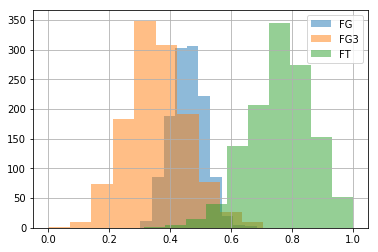

In [103]:
games['FG_PCT_HOME'].hist(label='FG', alpha=0.5)
games['FG3_PCT_HOME'].hist(label='FG3',alpha=0.5)
games['FT_PCT_HOME'].hist(label='FT',alpha=0.5)

plt.legend()

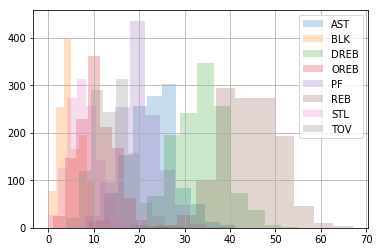

In [104]:
for col in totals_columns:
    games[col+'_HOME'].hist(label=col, alpha=0.25)
plt.legend()

In [105]:
from sklearn.preprocessing import StandardScaler
# Can scale teh columns in percent_columns.keys() + '_HOME' or '_AWAY' using StandardScaler

(0, 1.0)

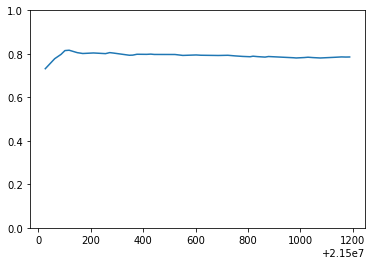

In [106]:
%matplotlib inline
plt.plot(games[games['TEAM_ABBREVIATION_HOME'] == 'ATL'].sort_values(by='GAME_DATE_HOME')['CumulFT_HOME'])
plt.ylim(0,1.0)

In [122]:
ts = pd.to_datetime(str(games["GAME_DATE_HOME"][0])).strftime("%Y-%m-%d")
type(ts)

str

Like the PlayerList() class, the GameIDs() class defaults to the current season. If we want the 2006-07 season, we need to identify and change the proper parameters. We can see the available parameters to set by printing the `api_params` attribute.

In [330]:
def Transform_data(game_lookup,game_stats):
    y = np.array([])
    i = 0
    for  j ,games in game_lookup.iterrows():
        date = \
        pd.to_datetime(str(games["GAME_DATE_HOME"])).strftime("%Y-%m-%d")
        home_team = games['TEAM_ABBREVIATION_HOME']
        away_team = games['TEAM_ABBREVIATION_AWAY']
        date_index_home = np.where(game_stats.loc[home_team].index==date)[0][0]
        date_index_away = np.where(game_stats.loc[away_team].index==date)[0][0]
        if date_index_away*date_index_home != 0:
            date_home = game_stats.loc[home_team].index[date_index_home-1]
            date_away = game_stats.loc[away_team].index[date_index_away-1]
            home_x = np.array(game_stats.loc[home_team,date_home].ix['AST':])
            away_x = np.array(game_stats.loc[away_team,date_away].ix['AST':])
            x = home_x-away_x
            y = np.append(y,games["point_spread"])
            if i == 0:
                X = x
                i += 1
            else:
                X = np.vstack((X,x))
    return X,y

In [331]:
X,y = Transform_data(games,all_stats)
X_train = X[0:999,:] ;y_train=y[0:999]
X_test = X[1000:,:]; y_test = y[1000:]

0.338028169014


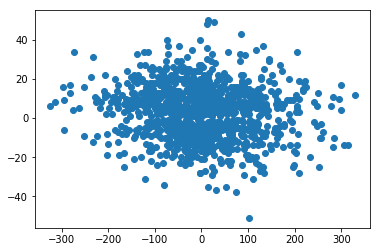

In [332]:
from sklearn.linear_model import LinearRegression, Ridge
a = 0.0001
Lin = Ridge(alpha = a,normalize=True)
fitLin = Lin.fit(X_train,y_train)
# plt.scatter(np.sign(fitLin.predict(X)),np.sign(y))
print(float(sum(np.sign(fitLin.predict(X_test))!= np.sign(y_test)))/y_test.shape[0])
# plt.plot(fitLin.coef_)
plt.scatter(X[:,15],y)

In [337]:
from sklearn.ensemble import GradientBoostingRegressor
GBM = GradientBoostingRegressor(max_depth=3)
fitGBM = GBM.fit(X_train,y_train)
print(float(sum(np.sign(fitGBM.predict(X_test))!= np.sign(y_test)))/y_test.shape[0])

0.328638497653


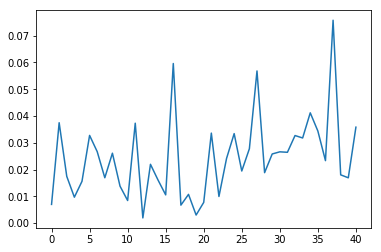

In [338]:
# plt.scatter((fitGBM.predict(X)),(y))
plt.plot(fitGBM.feature_importances_)

From there, we can see we should set the `Season` value to `2006-07`. Once we set the parameter, we need to get new data and then save the new data as a data frame to a new object.

In [4]:
gameids.get_new_data(Season='2016-17',PlayerOrTeam = "T")
gameids._set_api_parameters(Sorter = "GAME_DATE")
gameids2017 = pd.DataFrame(gameids.game_list())
gameids2017.head()["GAME_DATE"]

0    2017-01-28
1    2017-03-04
2    2017-02-10
3    2017-01-08
4    2016-12-10
Name: GAME_DATE, dtype: object

A quick filter for team names that contain 'Suns' returns all games for the Suns for the 2006-07 season

In [5]:
suns_logs = gameids2017.ix[gameids2017['TEAM_NAME'].str.contains('Suns')]
suns_logs.head()

,AST,BLK,DREB,FG3A,FG3M,FG3_PCT,FGA,FGM,FG_PCT,FTA,FTM,FT_PCT,GAME_DATE,GAME_ID,MATCHUP,MIN,OREB,PF,PLUS_MINUS,PTS,REB,SEASON_ID,STL,TEAM_ABBREVIATION,TEAM_ID,TEAM_NAME,TOV,VIDEO_AVAILABLE,WL
54,24,2,30,23,7,0.304,92,49,0.533,24,13,0.542,2017-03-30,0021601124,PHX vs. LAC,240,13,27,-6,118,43,22016,6,PHX,1610612756,Phoenix Suns,14,1,L
65,27,6,35,24,8,0.333,93,49,0.527,25,15,0.600,2017-02-24,0021600859,PHX @ CHI,265,8,23,-7,121,43,22016,8,PHX,1610612756,Phoenix Suns,19,1,L
67,32,10,47,24,10,0.417,88,49,0.557,34,29,0.853,2017-02-15,0021600844,PHX vs. LAL,240,12,20,36,137,59,22016,7,PHX,1610612756,Phoenix Suns,15,1,W
90,25,8,30,19,8,0.421,95,48,0.505,13,11,0.846,2017-02-10,0021600807,PHX vs. CHI,240,13,18,18,115,43,22016,4,PHX,1610612756,Phoenix Suns,9,1,W
98,21,2,20,24,10,0.417,89,48,0.539,17,14,0.824,2017-01-26,0021600692,PHX @ DEN,240,8,26,-7,120,28,22016,8,PHX,1610612756,Phoenix Suns,11,1,L


We can verify all of the games are there by checking the shape of the data frame.

In [6]:
suns_logs.shape

(82, 29)

In [7]:
gameids2017.columns.values

array([u'AST', u'BLK', u'DREB', u'FG3A', u'FG3M', u'FG3_PCT', u'FGA',
       u'FGM', u'FG_PCT', u'FTA', u'FTM', u'FT_PCT', u'GAME_DATE',
       u'GAME_ID', u'MATCHUP', u'MIN', u'OREB', u'PF', u'PLUS_MINUS',
       u'PTS', u'REB', u'SEASON_ID', u'STL', u'TEAM_ABBREVIATION',
       u'TEAM_ID', u'TEAM_NAME', u'TOV', u'VIDEO_AVAILABLE', u'WL'], dtype=object)

In [202]:
# game_team_2017 = gameids2017.groupby("TEAM_NAME")
# team_2017 = game_team_2017.apply(lambda x: x.sort_values('GAME_DATE'))

In [203]:
# num_team = 30; num_games = 82
# matrix = []
# names = []
# for i in range(0,num_team):
#     matrix.append(team_2017.iloc[0+num_games*i:num_games*(i+1)].to_dict('records'))
#     names.append(team_2017.iloc[num_games*i]["TEAM_NAME"])

In [204]:
# new = pd.DataFrame(matrix,index = names,columns = range(1,num_games+1))

In [8]:
def To_matrix(game_df):
    game_group = game_df.sort_values("TEAM_NAME").groupby("TEAM_NAME")
    game_sort = game_group.apply(lambda x: x.sort_values('GAME_DATE'))
    num_team = 30; num_games = 82
    matrix = []
    names = []
    for i in range(0,num_team):
        matrix.append(game_sort.iloc[0+num_games*i:num_games*(i+1)].to_dict('records'))
        names.append(game_sort.iloc[num_games*i]["TEAM_NAME"])
    new_game_df = pd.DataFrame(matrix,index = names,columns = range(1,num_games+1))
    return new_game_df

In [9]:
game_2014 = goldsberry.GameIDs(Season = "2014-15")
new_game_2014 = To_matrix(pd.DataFrame(game_2014.game_list()))

In [207]:
new_game_2014.head().loc["Atlanta Hawks",1]

{u'AST': 26,
 u'BLK': 8,
 u'DREB': 32,
 u'FG3A': 22,
 u'FG3M': 13,
 u'FG3_PCT': 0.591,
 u'FGA': 80,
 u'FGM': 40,
 u'FG_PCT': 0.5,
 u'FTA': 17,
 u'FTM': 9,
 u'FT_PCT': 0.529,
 u'GAME_DATE': u'2014-10-29',
 u'GAME_ID': u'0021400008',
 u'MATCHUP': u'ATL @ TOR',
 u'MIN': 240,
 u'OREB': 10,
 u'PF': 24,
 u'PLUS_MINUS': -7,
 u'PTS': 102,
 u'REB': 42,
 u'SEASON_ID': u'22014',
 u'STL': 6,
 u'TEAM_ABBREVIATION': u'ATL',
 u'TEAM_ID': 1610612737,
 u'TEAM_NAME': u'Atlanta Hawks',
 u'TOV': 19,
 u'VIDEO_AVAILABLE': 1,
 u'WL': u'L'}

In [10]:
new_game_2014.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,...,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82
Atlanta Hawks,"{u'MIN': 240, u'WL': u'L', u'TOV': 19, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 13, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 14, u'TEAM_...","{u'MIN': 290, u'WL': u'L', u'TOV': 19, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 9, u'TEAM_I...","{u'MIN': 240, u'WL': u'W', u'TOV': 16, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 22, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 13, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 19, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 11, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 10, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 11, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 14, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 18, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 14, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 16, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 19, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 11, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 12, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 16, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 18, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 12, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 11, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 10, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 9, u'TEAM_I...",...,"{u'MIN': 240, u'WL': u'W', u'TOV': 18, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 20, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 15, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 13, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 19, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 13, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 18, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 12, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 13, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 12, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 15, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 11, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 19, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 14, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 17, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 11, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 11, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 18, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 13, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 15, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 11, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 14, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 12, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 8, u'TEAM_I...","{u'MIN': 240, u'WL': u'L', u'TOV': 15, u'TEAM_..."
Boston Celtics,"{u'MIN': 240, u'WL': u'W', u'TOV': 13, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 11, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 17, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 28, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 12, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 12, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 9, u'TEAM_I...","{u'MIN': 240, u'WL': u'L', u'TOV': 14, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 19, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 15, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 12, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 8, u'TEAM_I...","{u'MIN': 240, u'WL': u'L', u'TOV': 13, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 15, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 23, u'TEAM_...","{u'MIN': 265, u'WL': u'W', u'TOV': 13, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 17, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 16, u'TEAM_...","{u'MIN': 290, u'WL': u'L', u'TOV': 17, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 15, u'TEAM_...","{u'MIN': 240, u'WL': u'L', u'TOV': 18, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 22, u'TEAM_...","{u'MIN': 240, u'WL': u'W', u'TOV': 14, u'TEAM_...","{u'MIN': 240, u'WL': u'W